In [139]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/rdgao/Documents/code/research/spectralCV/')
sys.path.append('/Users/rdgao/Documents/code/research/neurodsp/')
sys.path.append('/Users/rdgao/Documents/code/research/SpaceRecon/')

# imports
import numpy as np
import scipy as sp
import h5py
import matplotlib.pyplot as plt

import neurodsp as ndsp
from nlds import delayembed as de

CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']
font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 13}
import matplotlib
matplotlib.rc('font', **font)

import os
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
# load info file
infofile = '/Users/rdgao/Documents/data/CRCNS/hc3/sess_info.json'

# get info file
with open(infofile) as data_file:    
    info = json.load(data_file)
    
datafolder = '/Users/rdgao/Documents/data/CRCNS/hc3/'
num_sesh = len(info['sess'])

sesh = 3
cur_dir = (datafolder+info['rat'][str(sesh)]+'/'+info['sess'][str(sesh)])    
cur_sesh = info['rat'][str(sesh)]+'_'+info['sess'][str(sesh)]
print(cur_sesh)

# get sampling rate & number of shanks    
fs = (float(info['Fs'][str(sesh)]))
num_shanks = len(next(os.walk(cur_dir))[1])
data_all = []        
# traverse through all shanks
for sh in [9]:
    print(sh, end=',')
    datafile = (cur_dir+'/'+str(sh)+'/lfp0.mat')
    with h5py.File(datafile, 'r') as file:
        data_all.append(np.array(file['lfp'][:,0]))

data = np.stack(data_all)

ec014_ec014.183
9,

### Get a segment of data with theta oscillation

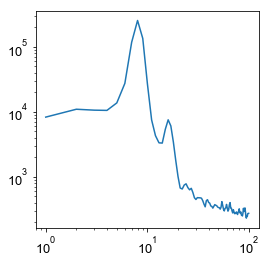

In [196]:
data_seg = data[0,50000:50000+int(fs*120)]
data_seg = data_seg-data_seg.mean() # demean
f_axis, psd = ndsp.spectral.psd(data_seg,fs)
plt.figure(figsize=(4,4))
plt.loglog(f_axis[:100],psd[:100])

/Users/rdgao/Documents/code/research/SpaceRecon/nlds/delayembed.py:187: RuntimeWarning: divide by zero encountered in true_divide
  del_R[:, dim] = abs(ndist) / dist[:, 1]
/Users/rdgao/Documents/code/research/SpaceRecon/nlds/delayembed.py:187: RuntimeWarning: invalid value encountered in true_divide
  del_R[:, dim] = abs(ndist) / dist[:, 1]


40 7
[0.97243453 0.91003474 0.53247595 0.14001203 0.02952966 0.0151256
 0.00989444 0.00588589]


/Users/rdgao/Documents/code/research/SpaceRecon/nlds/delayembed.py:225: RuntimeWarning: invalid value encountered in greater
  crit_1 = del_R[:, dim] > R_thr


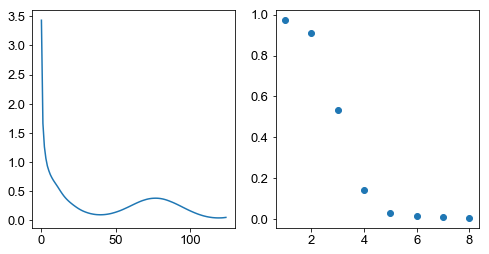

In [197]:
# compute delayed MI
delay, MI = de.compute_delay_MI(data_seg,50,max_tau=125)
tau, _ = de.find_valley(MI)
attr_dim, pfnn = de.pfnn_de_dim(data_seg,tau,max_dim=8)
print(tau, attr_dim)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(delay,MI)
plt.subplot(1,2,2)
plt.plot(range(1,1+len(pfnn)),pfnn, 'o')
print(pfnn)

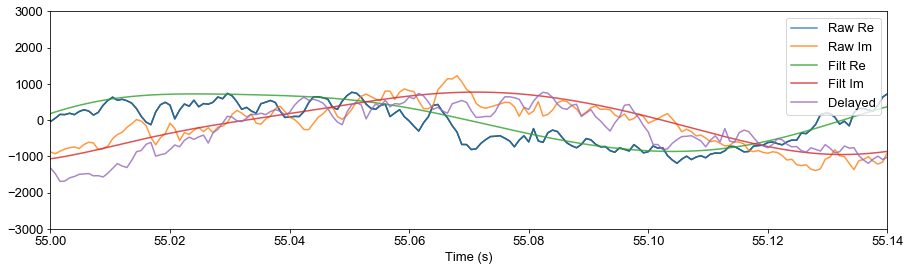

In [199]:
t = np.arange(0,len(data_seg))/fs
plot_win = [55,55.14]

# get data filtered & hilbert
data_filt = ndsp.filter(data_seg, fs, 'bandpass', 4, 20)
ht_filt = ndsp.timefrequency._hilbert_ignore_nan(data_filt)

# get broadband hilbert
ht = sp.signal.hilbert(data_seg)
#ht_ref = 1400*sp.signal.hilbert(np.cos(2*np.pi*6*t))


# plot
plt.figure(figsize=(15,4))
plt.plot(t,data_seg, 'k', alpha=0.8)
plt.plot(t,ht.real, alpha=0.8,label='Raw Re')
plt.plot(t,ht.imag, alpha=0.8,label='Raw Im')
plt.plot(t,ht_filt.real, alpha=0.8, label='Filt Re')
plt.plot(t,ht_filt.imag, alpha=0.8, label='Filt Im')
plt.plot(t[tau:],ht.real[:-tau], alpha=0.8, label='Delayed')
plt.xlim(plot_win)
plt.ylim([-3000, 3000])
plt.xlabel('Time (s)')
plt.legend()

# Observation:
The imaginary component (Hilbert transform) is not just the the signal shifted by a constant delay, which would be equivalent to linear phase delay for all frequencies. Instead, HT has constant phase delay for all frequencies, which re-align the Fourier phases.

Delay embedding at the optimal delay, however, very closely matches the time delay, presumably sharing the same phase delay as the dominant (oscillatory) component.

Text(0.5,1,'One Cycle')

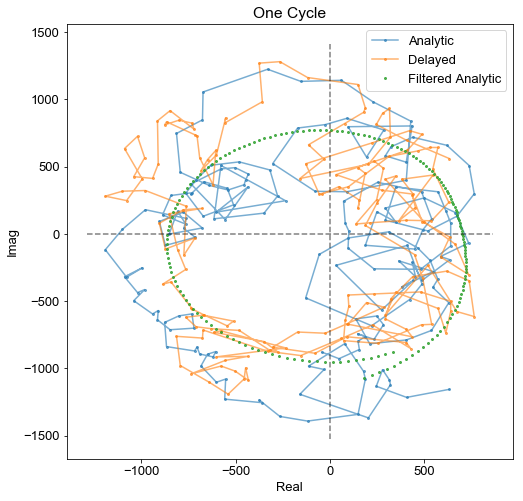

In [200]:
MS=4
plot_inds = np.arange(plot_win[0]*fs,plot_win[1]*fs).astype(int)
plt.figure(figsize=(8,8))
plt.plot(ht.real[plot_inds], ht.imag[plot_inds], '.-', ms=MS, alpha=0.6, label='Analytic') # analytic signal
plt.plot(ht.real[plot_inds], ht.real[plot_inds+tau], '.-', ms=MS, alpha=0.6, label='Delayed') # delay embedding
plt.plot(ht_filt.real[plot_inds], ht_filt.imag[plot_inds],  '.', ms=MS, alpha=0.8, label='Filtered Analytic')
plt.plot(plt.xlim(),[0,0],'k--', alpha=0.5)
plt.plot([0,0],plt.ylim(),'k--', alpha=0.5)
#plt.plot(ht_ref.real[plot_inds], ht_ref.imag[plot_inds], '.', alpha=0.5)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.legend()
plt.title('One Cycle')

# Question:
How to fit a non-symmetric and non-stationary ring around the points?

Ideas:
- Gaussian Process modeling
    - uninterpretable parameters
- fit ellipsoid
- fit a time-varying complex exponential, i.e. A( t )\* exp(j \* w(t) \* t)
    - that is literally a filtered sinusoid...
- delay forecasting fit
    - but this has no smoothness constraint
    
    
- https://stackoverflow.com/questions/31464345/fitting-a-closed-curve-to-a-set-of-points
- https://stackoverflow.com/questions/31243002/higher-order-local-interpolation-of-implicit-curves-in-python
- https://www.mathworks.com/matlabcentral/answers/224704-fitting-smooth-closed-spline-to-scattered-2d-points
- https://www.cs.cornell.edu/cv/OtherPdf/Ellipse.pdf
- http://scipy-cookbook.readthedocs.io/items/SavitzkyGolay.html